<a href="https://colab.research.google.com/github/vm1729/Openthink/blob/master/Learn%20Image/101_PyImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2
# define the dictionary of digit segments so we can identify
# each digit on the thermostat
DIGITS_LOOKUP = {
	(1, 1, 1, 0, 1, 1, 1): 0,
	(0, 0, 1, 0, 0, 1, 0): 1,
	(1, 0, 1, 1, 1, 1, 0): 2,
	(1, 0, 1, 1, 0, 1, 1): 3,
	(0, 1, 1, 1, 0, 1, 0): 4,
	(1, 1, 0, 1, 0, 1, 1): 5,
	(1, 1, 0, 1, 1, 1, 1): 6,
	(1, 0, 1, 0, 0, 1, 0): 7,
	(1, 1, 1, 1, 1, 1, 1): 8,
	(1, 1, 1, 1, 0, 1, 1): 9
}

In [3]:
from google.colab import files
upload=files.upload()

Saving thermostat.jpg to thermostat.jpg


In [0]:
# load the example image
image = cv2.imread("thermostat.jpg")

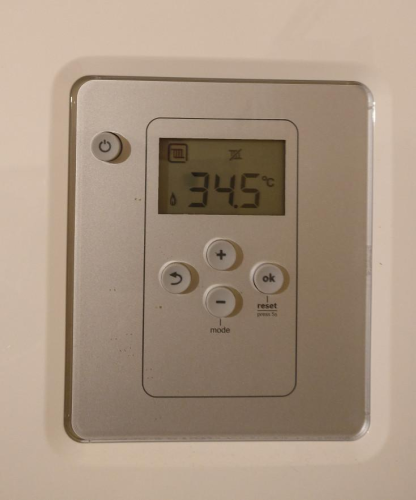

In [36]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [0]:
image = imutils.resize(image, height=500)
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
blurred=cv2.GaussianBlur(gray,(5,5),0)
edged=cv2.Canny(blurred,50,200,255)

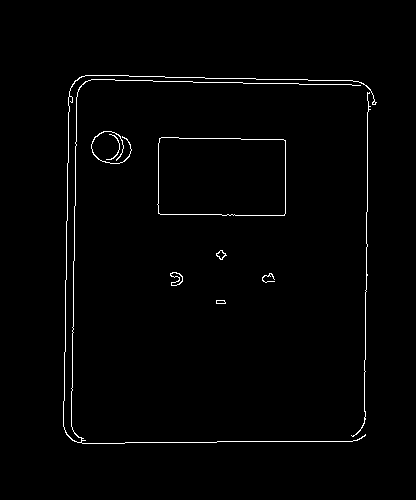

In [11]:
cv2_imshow(edged)

In [0]:
# find contours in the edge map, then sort them by their
# size in descending order
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
displayCnt = None
 
# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
	# if the contour has four vertices, then we have found
	# the thermostat display
	if len(approx) == 4:
		displayCnt = approx
		break

In [0]:
# extract the thermostat display, apply a perspective transform
# to it
warped = four_point_transform(gray, displayCnt.reshape(4, 2))
output = four_point_transform(image, displayCnt.reshape(4, 2))

In [0]:
thresh = cv2.threshold(warped, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

In [0]:
# find contours in the thresholded image, then initialize the
# digit contours lists
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digitCnts = []

# loop over the digit area candidates
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)

	# if the contour is sufficiently large, it must be a digit
	if w >= 15 and (h >= 30 and h <= 40):
		digitCnts.append(c)

In [24]:
digitCnts

[array([[[57, 35]],
 
        [[56, 36]],
 
        [[56, 49]],
 
        [[57, 50]],
 
        [[57, 51]],
 
        [[58, 51]],
 
        [[59, 52]],
 
        [[69, 52]],
 
        [[70, 53]],
 
        [[70, 63]],
 
        [[73, 66]],
 
        [[74, 66]],
 
        [[74, 58]],
 
        [[75, 57]],
 
        [[75, 52]],
 
        [[74, 51]],
 
        [[74, 49]],
 
        [[75, 48]],
 
        [[75, 35]],
 
        [[74, 35]],
 
        [[71, 38]],
 
        [[71, 47]],
 
        [[70, 48]],
 
        [[61, 48]],
 
        [[60, 47]],
 
        [[60, 37]],
 
        [[58, 35]]], dtype=int32), array([[[ 85,  33]],
 
        [[ 82,  36]],
 
        [[ 82,  49]],
 
        [[ 83,  50]],
 
        [[ 83,  51]],
 
        [[ 84,  51]],
 
        [[ 85,  52]],
 
        [[ 95,  52]],
 
        [[ 96,  53]],
 
        [[ 96,  60]],
 
        [[ 95,  61]],
 
        [[ 95,  62]],
 
        [[ 94,  63]],
 
        [[ 85,  63]],
 
        [[ 85,  67]],
 
        [[ 97,  67]],
 
        [[

In [0]:
# sort the contours from left-to-right, then initialize the
# actual digits themselves
digitCnts = contours.sort_contours(digitCnts,
	method="left-to-right")[0]
digits = []

In [0]:
# loop over each of the digits
for c in digitCnts:
	# extract the digit ROI
	(x, y, w, h) = cv2.boundingRect(c)
	roi = thresh[y:y + h, x:x + w]
 
	# compute the width and height of each of the 7 segments
	# we are going to examine
	(roiH, roiW) = roi.shape
	(dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
	dHC = int(roiH * 0.05)
 
	# define the set of 7 segments
	segments = [
		((0, 0), (w, dH)),	# top
		((0, 0), (dW, h // 2)),	# top-left
		((w - dW, 0), (w, h // 2)),	# top-right
		((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
		((0, h // 2), (dW, h)),	# bottom-left
		((w - dW, h // 2), (w, h)),	# bottom-right
		((0, h - dH), (w, h))	# bottom
	]
	on = [0] * len(segments)

In [28]:
	# loop over the segments
	for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
		# extract the segment ROI, count the total number of
		# thresholded pixels in the segment, and then compute
		# the area of the segment
		segROI = roi[yA:yB, xA:xB]
		total = cv2.countNonZero(segROI)
		area = (xB - xA) * (yB - yA)

		# if the total number of non-zero pixels is greater than
		# 50% of the area, mark the segment as "on"
		if total / float(area) > 0.5:
			on[i]= 1

	# lookup the digit and draw it on the image
	digit = DIGITS_LOOKUP[tuple(on)]
	digits.append(digit)
	cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
	cv2.putText(output, str(digit), (x - 10, y - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
  
  

array([[[ 51,  65,  83],
        [ 17,  31,  49],
        [ 18,  32,  50],
        ...,
        [ 14,  33,  50],
        [ 19,  39,  57],
        [ 55,  76,  94]],

       [[ 47,  61,  79],
        [ 16,  30,  48],
        [ 15,  29,  47],
        ...,
        [ 14,  34,  50],
        [ 13,  33,  50],
        [ 53,  74,  92]],

       [[ 48,  62,  80],
        [ 21,  35,  53],
        [ 19,  33,  51],
        ...,
        [ 19,  39,  54],
        [ 17,  37,  53],
        [ 56,  76,  94]],

       ...,

       [[ 44,  60,  77],
        [ 28,  44,  61],
        [ 29,  45,  62],
        ...,
        [ 29,  50,  65],
        [ 24,  45,  60],
        [ 29,  49,  65]],

       [[ 43,  59,  76],
        [ 27,  43,  60],
        [ 29,  45,  62],
        ...,
        [ 26,  47,  62],
        [ 21,  42,  57],
        [ 31,  51,  67]],

       [[ 45,  61,  78],
        [ 30,  46,  63],
        [ 29,  45,  62],
        ...,
        [ 56,  77,  92],
        [ 56,  77,  92],
        [ 65,  85, 101]]

In [35]:
on[2]

0

In [32]:
digits

[5]